In [1]:
!pip install -q --upgrade pip
!pip install -q git+https://github.com/Cadene/pretrained-models.pytorch
!pip install -q six numpy scipy Pillow matplotlib scikit-image opencv-python imageio
!pip install -q --no-dependencies imgaug
!pip install -q torch_optimizer

     |████████████████████████████████| 1.5MB 4.8MB/s 


In [20]:
import numpy as np 
import pandas as pd 
import glob
import cv2
from tqdm.auto import tqdm

from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_optimizer import RAdam

from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam,SGD
from sklearn.model_selection import train_test_split


import torchvision as tv
import imgaug.augmenters as iaa
import imgaug as ia
import pretrainedmodels
from pretrainedmodels import resnet50, resnext101_32x4d 
from torch.optim import lr_scheduler
import copy
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [21]:

SEED = 42

train_path = glob.glob('/content/drive/My Drive/Colab Notebooks/CV/224-224-cervical-cancer-screening/kaggle/train/train/*/*.jpg')
train, validation = train_test_split(train_path, test_size=0.1, random_state=SEED)
test = glob.glob('/content/drive/My Drive/Colab Notebooks/CV/224-224-cervical-cancer-screening/kaggle/test/test/*.jpg')

len(train), len(validation), len(test)

(1332, 149, 512)

In [0]:
ia.seed(SEED)
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

seq = iaa.Sequential([
                        sometimes(iaa.ElasticTransformation(alpha=(0, 10), sigma=10)),
                        sometimes(iaa.Affine(translate_px=(-30, 30), rotate=(-120, 120), cval=0)),
                        sometimes(iaa.Crop(percent=(0, 0.1))),
                        sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05)))],
            random_order=True)

train_transfroms =  tv.transforms.Compose([
        tv.transforms.RandomHorizontalFlip(),
        tv.transforms.RandomRotation((-120,120)),
        tv.transforms.ToTensor(),
        tv.transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
        ])

test_transfroms =  tv.transforms.Compose([
        tv.transforms.ToTensor(),
        tv.transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
        ])



In [0]:
class LeNetModel(nn.Module):
    param_conv1 = {
        'in_channels': 3,
        'out_channels': 6,
        'kernel_size':(5,5)
    }
    max_pooling_kize1 = 2

    param_conv2 = {
        'in_channels': 6,
        'out_channels': 16,
        'kernel_size':(5,5)
    }

    max_pooling_kize2 = 2

    param_fc1 = { 
        'in_features' :53*53*16, 
        'out_features':120
    }
    
    param_fc2 = {
        'in_features' : 120,
        'out_features': 84
    }
    
    param_fc3 = {
        'in_features' : 84,
        'out_features': 3
    }

    
    def __init__(self):
         super(LeNetModel, self).__init__()
         self.conv1 = nn.Conv2d(**self.param_conv1)
         self.conv2 = nn.Conv2d(**self.param_conv2)

         self.fc1 = nn.Linear(**self.param_fc1)
         self.fc2 = nn.Linear(**self.param_fc2)
         self.fc3 = nn.Linear(**self.param_fc3)

    def forward(self,x):
        x = self.conv1(x.float())
        x = F.relu(x)
        x = F.max_pool2d(x,self.max_pooling_kize1)

        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x,self.max_pooling_kize2)

        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = F.relu(x)
        return F.log_softmax(self.fc3(x),dim=1)

class CervicalCancerDataset(Dataset):
    def __init__(self, data, transform=None, preprocess=None, size=None):
        super(CervicalCancerDataset,self).__init__()
        self.data = data
        self.preprocess = preprocess
        self.transform = transform
        self.size = size

    def __getitem__(self, idx):
        
        image = cv2.imread(self.data[idx])
        file_name = self.data[idx].split('/')[-1]
        
        # Bad labeling fix 
        if file_name == '80.jpg':  
            label = 2
        elif file_name == '968.jpg' or file_name == '1120.jpg':  
            label = 0
        else:
            label = int(self.data[idx].split('/')[-2][-1]) - 1 

        if self.size != None:
            image = cv2.resize(image,(self.size,self.size),cv2.INTER_AREA)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        
        if self.preprocess:
            image = self.preprocess(image)  
            
        if self.transform:
            image = tv.transforms.ToPILImage()(image)
            image = self.transform(image)
        # target = np.zeros(3)
        # target[int(label)-1] = 1.0
        return image, label
    
    def __len__(self):
        return len(self.data)

def normalize(img):
    img -=img.min()
    img/=img.max()
    return img


def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)


In [0]:
def fit_model(model, criterion, optimizer, scheduler, epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses, val_losses,train_accs, val_accs = [], [], [], []
    model.to(device)
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_acc = 0
        running_loss = 0
        total = 0
        correct = 0
        for data in tqdm(train_loader, desc=f'[Epoch {epoch+1}/{epochs}]'):
            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.step()
            total += labels.size(0)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / total
        train_acc = correct / total
    
        running_loss = 0
        total = 0
        correct = 0
        model.eval()

        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = val_data[0].to(device),val_data[1].to(device)
                val_outputs = model(val_inputs)

                loss = criterion(val_outputs, val_labels)
                running_loss += loss.item() * val_inputs.size(0)

                #count prediction hits
                _, predicted = torch.max(val_outputs, 1)
                total += val_labels.size(0)
                correct += (predicted == val_labels).sum().item()

        val_loss = running_loss / total
        val_acc = correct / total
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)  
        train_accs.append(train_acc)  
        val_accs.append(val_acc)  
        print(f"Epoch {epoch+1}/{epochs}\t"
            f"Train loss: {train_loss:.5f}\t"
            f"Train accuracy: {(train_acc)*100:.3f}\t"
            f"Validation loss: {val_loss:.5f} \t "
            f"Validation accuracy: {(val_acc)*100:.3f}")

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        scheduler.step()

    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses,train_accs, val_accs

In [0]:
batch_size = 20
train_data = CervicalCancerDataset(data=train, transform=train_transfroms, preprocess=seq.augment_image,size=224)    
train_loader = DataLoader(train_data,batch_size=batch_size,shuffle=True,num_workers=4)

validation_data = CervicalCancerDataset(data=validation, transform=test_transfroms, preprocess=None,size=224)    
val_loader = DataLoader(validation_data,batch_size=batch_size,shuffle=True,num_workers=4)


In [38]:
model_lenet = LeNetModel()
model_lenet.apply(init_weights)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model_lenet.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


model_lenet, lenet_train_losses, lenet_val_losses, lenet_train_acc, lenet_val_acc = fit_model(model_lenet, criterion, optimizer, scheduler)


Epoch 1/25	Train loss: 1.31656	Train accuracy: 49.324	Validation loss: 0.98420 	 Validation accuracy: 56.376



Epoch 2/25	Train loss: 1.00606	Train accuracy: 51.201	Validation loss: 0.97320 	 Validation accuracy: 56.376



Epoch 3/25	Train loss: 1.00185	Train accuracy: 51.952	Validation loss: 0.95789 	 Validation accuracy: 51.007



Epoch 4/25	Train loss: 0.99736	Train accuracy: 52.402	Validation loss: 0.99289 	 Validation accuracy: 56.376



Epoch 5/25	Train loss: 1.00597	Train accuracy: 51.727	Validation loss: 0.97487 	 Validation accuracy: 57.047



Epoch 6/25	Train loss: 0.99463	Train accuracy: 52.252	Validation loss: 0.95309 	 Validation accuracy: 56.376



Epoch 7/25	Train loss: 0.96637	Train accuracy: 53.303	Validation loss: 0.95081 	 Validation accuracy: 56.376



Epoch 8/25	Train loss: 0.95453	Train accuracy: 53.529	Validation loss: 0.91248 	 Validation accuracy: 57.718



Epoch 9/25	Train loss: 0.91466	Train accuracy: 55.856	Validation loss: 0.91687 	 Validation accuracy: 57.718



Epoch 10/25	Train loss: 0.92281	Train accuracy: 55.405	Validation loss: 0.89924 	 Validation accuracy: 59.732



Epoch 11/25	Train loss: 0.90891	Train accuracy: 54.880	Validation loss: 0.90396 	 Validation accuracy: 60.403



Epoch 12/25	Train loss: 0.90337	Train accuracy: 56.156	Validation loss: 0.89274 	 Validation accuracy: 59.060



Epoch 13/25	Train loss: 0.90117	Train accuracy: 57.883	Validation loss: 0.90047 	 Validation accuracy: 62.416



Epoch 14/25	Train loss: 0.89495	Train accuracy: 56.532	Validation loss: 0.89977 	 Validation accuracy: 59.060



Epoch 15/25	Train loss: 0.87788	Train accuracy: 57.883	Validation loss: 0.89769 	 Validation accuracy: 61.074



Epoch 16/25	Train loss: 0.88647	Train accuracy: 58.408	Validation loss: 0.89519 	 Validation accuracy: 61.074



Epoch 17/25	Train loss: 0.88324	Train accuracy: 58.333	Validation loss: 0.89439 	 Validation accuracy: 59.732



Epoch 18/25	Train loss: 0.88009	Train accuracy: 58.333	Validation loss: 0.89338 	 Validation accuracy: 61.074



Epoch 19/25	Train loss: 0.87692	Train accuracy: 58.634	Validation loss: 0.89217 	 Validation accuracy: 61.074



Epoch 20/25	Train loss: 0.87197	Train accuracy: 58.108	Validation loss: 0.89404 	 Validation accuracy: 60.403



Epoch 21/25	Train loss: 0.88721	Train accuracy: 56.832	Validation loss: 0.89220 	 Validation accuracy: 61.074



Epoch 22/25	Train loss: 0.87834	Train accuracy: 58.033	Validation loss: 0.89213 	 Validation accuracy: 61.074



Epoch 23/25	Train loss: 0.88074	Train accuracy: 56.982	Validation loss: 0.89189 	 Validation accuracy: 61.074



Epoch 24/25	Train loss: 0.88934	Train accuracy: 56.757	Validation loss: 0.89193 	 Validation accuracy: 61.074



Epoch 25/25	Train loss: 0.88820	Train accuracy: 56.757	Validation loss: 0.89194 	 Validation accuracy: 61.074


# Restnet50

In [0]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [40]:
resnet = pretrainedmodels.__dict__['resnet50'](num_classes=1000, pretrained='imagenet')
dim_in = resnet.last_linear.in_features
resnet.last_linear = torch.nn.Sequential(nn.Linear(dim_in,512),
                            nn.ReLU(),
                            nn.Dropout(),
                            nn.Linear(512,3),
                            nn.LogSoftmax(dim=1))

resnet.last_linear.apply(init_weights)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(resnet.parameters(),lr=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

resnet, resnet_train_losses, resnet_val_losses, resnet_train_acc, resnet_val_acc = fit_model(resnet, criterion, optimizer, scheduler)



Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth



Epoch 1/25	Train loss: 1.03618	Train accuracy: 50.976	Validation loss: 0.87744 	 Validation accuracy: 65.101



Epoch 2/25	Train loss: 0.85006	Train accuracy: 62.688	Validation loss: 0.81936 	 Validation accuracy: 59.732



Epoch 3/25	Train loss: 0.80683	Train accuracy: 63.438	Validation loss: 0.91344 	 Validation accuracy: 65.772



Epoch 4/25	Train loss: 0.74650	Train accuracy: 68.619	Validation loss: 0.80711 	 Validation accuracy: 67.785



Epoch 5/25	Train loss: 0.70505	Train accuracy: 68.994	Validation loss: 0.78171 	 Validation accuracy: 65.101



Epoch 6/25	Train loss: 0.68661	Train accuracy: 69.144	Validation loss: 0.73636 	 Validation accuracy: 67.785



Epoch 7/25	Train loss: 0.68378	Train accuracy: 70.120	Validation loss: 0.76350 	 Validation accuracy: 67.114



Epoch 8/25	Train loss: 0.61391	Train accuracy: 73.423	Validation loss: 0.71737 	 Validation accuracy: 72.483



Epoch 9/25	Train loss: 0.57844	Train accuracy: 75.976	Validation loss: 0.74647 	 Validation accuracy: 69.128



Epoch 10/25	Train loss: 0.53585	Train accuracy: 77.628	Validation loss: 0.74610 	 Validation accuracy: 69.799



Epoch 11/25	Train loss: 0.54834	Train accuracy: 76.351	Validation loss: 0.75598 	 Validation accuracy: 68.456



Epoch 12/25	Train loss: 0.52089	Train accuracy: 77.928	Validation loss: 0.75087 	 Validation accuracy: 68.456



Epoch 13/25	Train loss: 0.53141	Train accuracy: 77.327	Validation loss: 0.77239 	 Validation accuracy: 66.443



Epoch 14/25	Train loss: 0.48921	Train accuracy: 78.453	Validation loss: 0.76457 	 Validation accuracy: 68.456



Epoch 15/25	Train loss: 0.47605	Train accuracy: 79.805	Validation loss: 0.75927 	 Validation accuracy: 67.114



Epoch 16/25	Train loss: 0.46671	Train accuracy: 80.631	Validation loss: 0.75826 	 Validation accuracy: 68.456



Epoch 17/25	Train loss: 0.44559	Train accuracy: 80.931	Validation loss: 0.75986 	 Validation accuracy: 69.799



Epoch 18/25	Train loss: 0.47392	Train accuracy: 79.955	Validation loss: 0.76556 	 Validation accuracy: 68.456



Epoch 19/25	Train loss: 0.46302	Train accuracy: 80.781	Validation loss: 0.77895 	 Validation accuracy: 66.443



Epoch 20/25	Train loss: 0.47620	Train accuracy: 81.006	Validation loss: 0.78042 	 Validation accuracy: 69.128



Epoch 21/25	Train loss: 0.47572	Train accuracy: 79.655	Validation loss: 0.77398 	 Validation accuracy: 67.785



Epoch 22/25	Train loss: 0.45575	Train accuracy: 81.456	Validation loss: 0.78347 	 Validation accuracy: 67.114



Epoch 23/25	Train loss: 0.46891	Train accuracy: 80.631	Validation loss: 0.77095 	 Validation accuracy: 67.114



Epoch 24/25	Train loss: 0.45312	Train accuracy: 80.706	Validation loss: 0.78557 	 Validation accuracy: 65.772



Epoch 25/25	Train loss: 0.44700	Train accuracy: 81.682	Validation loss: 0.76578 	 Validation accuracy: 68.456


In [41]:
resnext = resnext101_32x4d(num_classes=1000, pretrained='imagenet')
dim_in = resnext.last_linear.in_features
resnext.last_linear = torch.nn.Sequential(
                            nn.Linear(dim_in,512),
                            nn.ReLU(),
                            nn.Dropout(),
                            nn.Linear(512,3),
                            nn.LogSoftmax(dim=1))

resnext.last_linear.apply(init_weights)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(resnext.parameters(),lr=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

resnext, resnext_train_losses, resnext_val_losses, resnext_train_acc, resnext_val_acc  = fit_model(resnext, criterion, optimizer, scheduler)

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/resnext101_32x4d-29e315fa.pth" to /root/.cache/torch/checkpoints/resnext101_32x4d-29e315fa.pth



Epoch 1/25	Train loss: 1.09018	Train accuracy: 52.402	Validation loss: 0.88699 	 Validation accuracy: 68.456



Epoch 2/25	Train loss: 0.86472	Train accuracy: 62.763	Validation loss: 0.80010 	 Validation accuracy: 64.430



Epoch 3/25	Train loss: 0.77579	Train accuracy: 66.441	Validation loss: 0.83697 	 Validation accuracy: 64.430



Epoch 4/25	Train loss: 0.75843	Train accuracy: 67.192	Validation loss: 0.83970 	 Validation accuracy: 59.060



Epoch 5/25	Train loss: 0.71824	Train accuracy: 68.093	Validation loss: 0.71202 	 Validation accuracy: 67.785



Epoch 6/25	Train loss: 0.68076	Train accuracy: 70.495	Validation loss: 0.84111 	 Validation accuracy: 60.403



Epoch 7/25	Train loss: 0.64267	Train accuracy: 72.898	Validation loss: 0.85729 	 Validation accuracy: 66.443



Epoch 8/25	Train loss: 0.55508	Train accuracy: 76.952	Validation loss: 0.82767 	 Validation accuracy: 67.785



Epoch 9/25	Train loss: 0.50535	Train accuracy: 78.453	Validation loss: 0.82379 	 Validation accuracy: 67.114



Epoch 10/25	Train loss: 0.47886	Train accuracy: 80.706	Validation loss: 0.84422 	 Validation accuracy: 64.430



Epoch 11/25	Train loss: 0.46850	Train accuracy: 79.354	Validation loss: 0.84493 	 Validation accuracy: 66.443



Epoch 12/25	Train loss: 0.43543	Train accuracy: 81.757	Validation loss: 0.86899 	 Validation accuracy: 66.443



Epoch 13/25	Train loss: 0.44838	Train accuracy: 81.832	Validation loss: 0.83532 	 Validation accuracy: 66.443



Epoch 14/25	Train loss: 0.37567	Train accuracy: 85.210	Validation loss: 0.94143 	 Validation accuracy: 64.430



Epoch 15/25	Train loss: 0.38036	Train accuracy: 84.685	Validation loss: 0.93400 	 Validation accuracy: 65.772



Epoch 16/25	Train loss: 0.36532	Train accuracy: 84.835	Validation loss: 0.92988 	 Validation accuracy: 64.430



Epoch 17/25	Train loss: 0.34782	Train accuracy: 86.862	Validation loss: 0.92140 	 Validation accuracy: 65.772



Epoch 18/25	Train loss: 0.36493	Train accuracy: 85.736	Validation loss: 0.92123 	 Validation accuracy: 66.443



Epoch 19/25	Train loss: 0.34916	Train accuracy: 85.811	Validation loss: 0.93581 	 Validation accuracy: 69.128



Epoch 20/25	Train loss: 0.34929	Train accuracy: 86.862	Validation loss: 0.94462 	 Validation accuracy: 67.785



Epoch 21/25	Train loss: 0.33315	Train accuracy: 86.637	Validation loss: 0.96562 	 Validation accuracy: 65.101



Epoch 22/25	Train loss: 0.33400	Train accuracy: 87.913	Validation loss: 0.94846 	 Validation accuracy: 66.443



Epoch 23/25	Train loss: 0.34497	Train accuracy: 86.186	Validation loss: 0.93598 	 Validation accuracy: 67.114



Epoch 24/25	Train loss: 0.31564	Train accuracy: 87.838	Validation loss: 0.94691 	 Validation accuracy: 66.443



Epoch 25/25	Train loss: 0.34410	Train accuracy: 88.138	Validation loss: 0.94769 	 Validation accuracy: 65.772


In [0]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

def show_scores(model, loader):
    correct = 0
    total = 0
    y_preds = np.array([])
    y_actual = np.array([])
    with torch.no_grad():
        for data in loader:
            images, labels = data[0].to(device),data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_preds = np.append(y_preds,predicted.cpu().detach().numpy())
            y_actual = np.append(y_actual,labels.cpu().detach().numpy())
    cm = confusion_matrix(y_actual, y_preds)
    df_cm = pd.DataFrame(cm, range(3), range(3))
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True,cmap='Blues')
    plt.show()
    print('Accuracy of the network on the validation images: %.3f %%' % ((correct / total)* 100))
    
    

def plot_losses(train_losses,val_losses,title):
    plt.plot(train_losses,'b')
    plt.plot(val_losses,'g')
    plt.xlabel('Iterations')
    plt.ylabel('loss')
    plt.legend(['Train','Validation'])
    plt.title(title)
    plt.show()


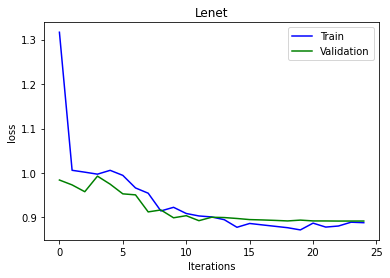

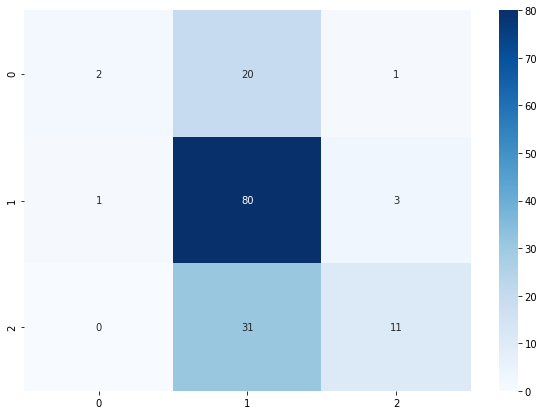

Accuracy of the network on the validation images: 62.416 %


In [105]:
plot_losses(lenet_train_losses, lenet_val_losses, 'Lenet')
show_scores(model_lenet, val_loader)


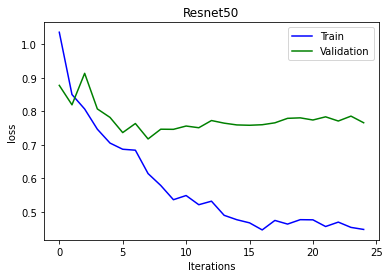

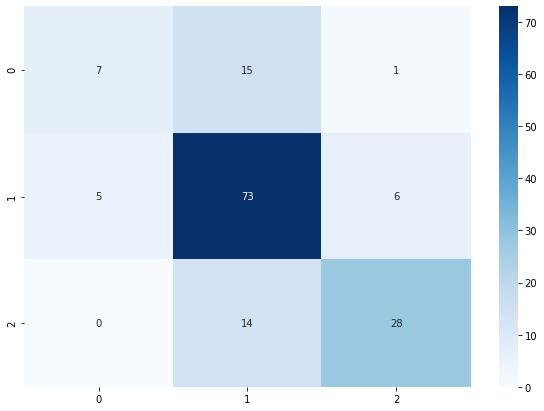

Accuracy of the network on the validation images: 72.483 %


In [106]:
plot_losses(resnet_train_losses, resnet_val_losses,'Resnet50')
show_scores(resnet,  val_loader)

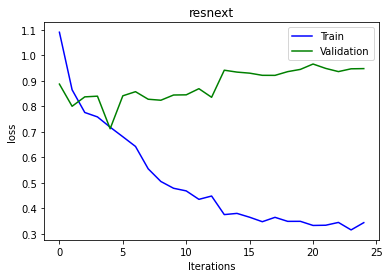

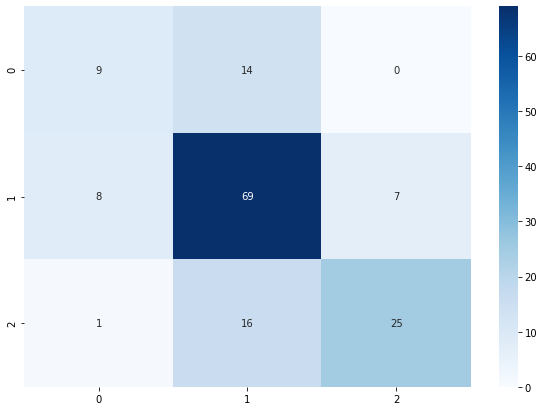

Accuracy of the network on the validation images: 69.128 %


In [107]:

plot_losses(resnext_train_losses, resnext_val_losses,'resnext')
show_scores(resnext,  val_loader)

# Summary
As we can see the number of epochs that I've chose are high, after aprox. 10 epochs the model got over fitted. But, after each epoch on the fitting stage I saved tha weights where the accuracy on the validation set was high and therefore the best model weights, and after the epochs i returned the model with the best weights. 

### Scores
The best model was the resnet with 72% accuracy.

# Save the models

In [0]:
torch.save(model_lenet.state_dict(), 'model_Lenet.pt')
torch.save(resnet.state_dict(), 'model_renet.pt')
torch.save(resnext.state_dict(), 'model_renext.pt')

# Submission

In [0]:
#!pip install kaggle
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !ls ~/.kaggle
# !chmod 600 /root/.kaggle/kaggle.json

In [109]:
test = glob.glob('/content/drive/My Drive/Colab Notebooks/CV/224-224-cervical-cancer-screening/kaggle/test/test/*.jpg')
test += glob.glob('/content/drive/My Drive/Colab Notebooks/CV/224-224-cervical-cancer-screening/kaggle/test_stg2/*.jpg')
len(test)

4018

In [0]:
class CervicalCancerTestDataset(Dataset):
    def __init__(self, data,transform=None, size=None):
        super(CervicalCancerTestDataset,self).__init__()
        self.data = data
        self.transform = transform
        self.size = size

    def __getitem__(self, idx):
        image = cv2.imread(self.data[idx])
        file_name = self.data[idx].split('/')[-1]

        if self.size != None:
            image = cv2.resize(image,(self.size,self.size),cv2.INTER_AREA)

        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image)

        return image, file_name 

    def __len__(self):
        return len(self.data)


test_data = CervicalCancerTestDataset(data=test,transform=test_transfroms, size=224)    
test_loader = DataLoader(test_data,batch_size=batch_size,shuffle=False,num_workers=4)

In [227]:
def test_model(model):
    df = pd.DataFrame(columns=['image_name','Type_1','Type_2','Type_3'])
    file_names = np.array([])
    predictions = np.array([])
    model.eval()

    with torch.no_grad():
        for data in tqdm(test_loader, desc=f'Test'):
            images, file_ = data[0].to(device),data[1]
            outputs = model(images)
            outputs = torch.exp(outputs).cpu().detach().numpy() # e^Log(softmax(x)) == softmax(x)
            file_names = np.append(file_names,file_)
            if len(predictions) == 0:
                predictions = outputs
            else:
                predictions = np.append(predictions,outputs,axis=0)

    for i,(name,out) in enumerate(zip(file_names,predictions)):
        df.loc[i] = [name] + list(out)

    return df

# submission = test_model(model_lenet)
# submission = test_model(resnet)
submission = test_model(resnext)
submission.to_csv('submission.csv',index=False)

In [230]:
# !kaggle competitions submit -c intel-mobileodt-cervical-cancer-screening -f submission.csv -m "Lenet-submission"
# !kaggle competitions submit -c intel-mobileodt-cervical-cancer-screening -f submission.csv -m "resnet-submission"
!kaggle competitions submit -c intel-mobileodt-cervical-cancer-screening -f submission.csv -m "resnext-submission"

100% 275k/275k [00:01<00:00, 147kB/s]
Successfully submitted to Intel & MobileODT Cervical Cancer Screening

# Kaggle Results:

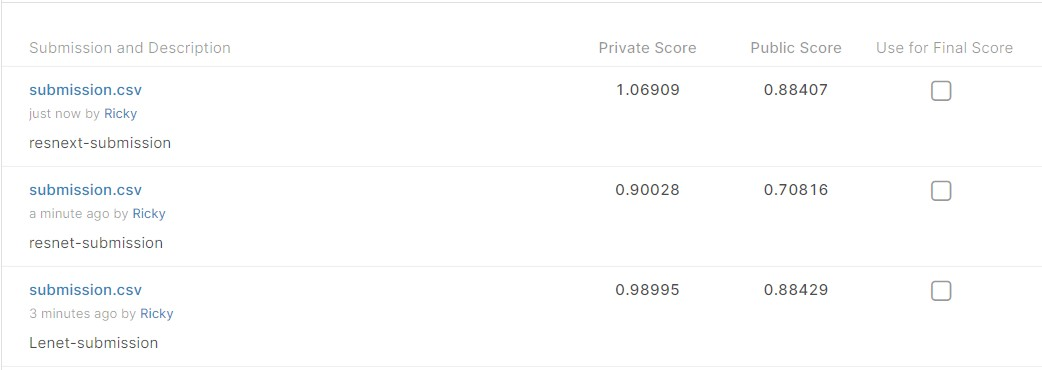